In [1]:
%load_ext lab_black

In [2]:
import requests

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")


Bad key "text.kerning_factor" on line 4 in
/home/paul/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Connect to mev-inspect Postgres DB

In [3]:
import psycopg2

conn_string = "host='localhost' dbname='mev_inspect' user='postgres' password='password' port='6543'"
conn = psycopg2.connect(conn_string)

### Pull token reference data

In [4]:
token_ref = pd.DataFrame(
    requests.get("https://tokens.coingecko.com/uniswap/all.json").json()["tokens"]
)
token_ref.head()

token_ref_mapper = token_ref.set_index("address")["symbol"].to_dict()
token_decimals_mapper = token_ref.set_index("address")["decimals"].to_dict()

### Pull Block Data

In [5]:
df_blocks = pd.read_sql(
    """
    select 
    *
    from blocks
    """,
    conn,
)
df_blocks["block_timestamp"] = pd.to_datetime(df_blocks["block_timestamp"])

In [6]:
d = df_blocks.block_timestamp.max() - df_blocks.block_timestamp.min()
f"Data Spanning {d}"

'Data Spanning 0 days 20:20:38'

In [7]:
df_blocks.shape

(5192, 2)

### Pull Arb data

In [8]:
df_arbs = pd.read_sql("select * from arbitrages", conn)
df_arbs["protocols_flat"] = [",".join(map(str, l)) for l in df_arbs["protocols"]]
df_arbs["profit_token_symbol"] = df_arbs.profit_token_address.map(token_ref_mapper)
df_arbs["profit_token_decimals"] = df_arbs.profit_token_address.map(
    token_decimals_mapper
)

df_arbs["profit_amount"] = (
    df_arbs["profit_amount"] / 10 ** df_arbs["profit_token_decimals"]
)

## Arbitrage EDA

In [9]:
df_arbs.shape

(1412, 14)

In [10]:
df_arbs.head(5)

,id,created_at,account_address,profit_token_address,block_number,transaction_hash,start_amount,end_amount,profit_amount,error,protocols,protocols_flat,profit_token_symbol,profit_token_decimals
0,5c5b763e-c7a1-424b-988f-2dc3ae79609c,2022-05-29 12:34:47.514630,0x5aa3393e361c2eb342408559309b3e873cd876d6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,14866456.0,0x371d55e596cc9caafd62b7bae471d6210821b4245286...,6.922130e+17,6.988036e+17,0.006591,None,"[uniswap_v2, uniswap_v3]","uniswap_v2,uniswap_v3",WETH,18
1,871c2a42-5214-4c8e-a944-5c32441f4883,2022-05-29 12:34:47.514630,0xab319a82803ea5f8f335dc373ce248008d4f2671,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,14866456.0,0xa4afe8bf0d01a3b4a50149a22f71aa58a65948971cb6...,5.098398e+17,5.130708e+17,0.003231,None,[uniswap_v2],uniswap_v2,WETH,18
2,37a4753f-6a03-420f-a6f1-a7c8b04401ef,2022-05-29 12:34:54.983479,0x8e60b2b96ea901beb2cafd79b8d0ed249a5efd95,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,14866457.0,0x46a768216a9c6eddfefc1fe0d6ef40646a0fc37f40f3...,3.027974e+17,3.066322e+17,0.003835,None,"[uniswap_v2, uniswap_v3]","uniswap_v2,uniswap_v3",WETH,18
3,6b4fe798-9ebb-4899-aa29-fc6f8fa49453,2022-05-29 12:36:19.978593,0x5aa3393e361c2eb342408559309b3e873cd876d6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,14866463.0,0x78e3d79f17c11041d5cd04250b669e5fc4ff929665e1...,2.373620e+17,2.415266e+17,0.004165,None,[uniswap_v2],uniswap_v2,WETH,18
4,5101863e-3a84-48d7-a64a-21af47e45577,2022-05-29 12:37:44.400872,0x0eae044f00b0af300500f090ea00027097d03000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,14866469.0,0x62990cf80cebb94d4ff11dc41554574cbf49b9867e80...,3.407149e+17,3.454248e+17,0.004710,None,[uniswap_v2],uniswap_v2,WETH,18


In [11]:
df_arbs.profit_token_symbol.value_counts()

WETH    1342
USDC      38
USDT      26
DAI        4
WBTC       1
FRAX       1
Name: profit_token_symbol, dtype: int64

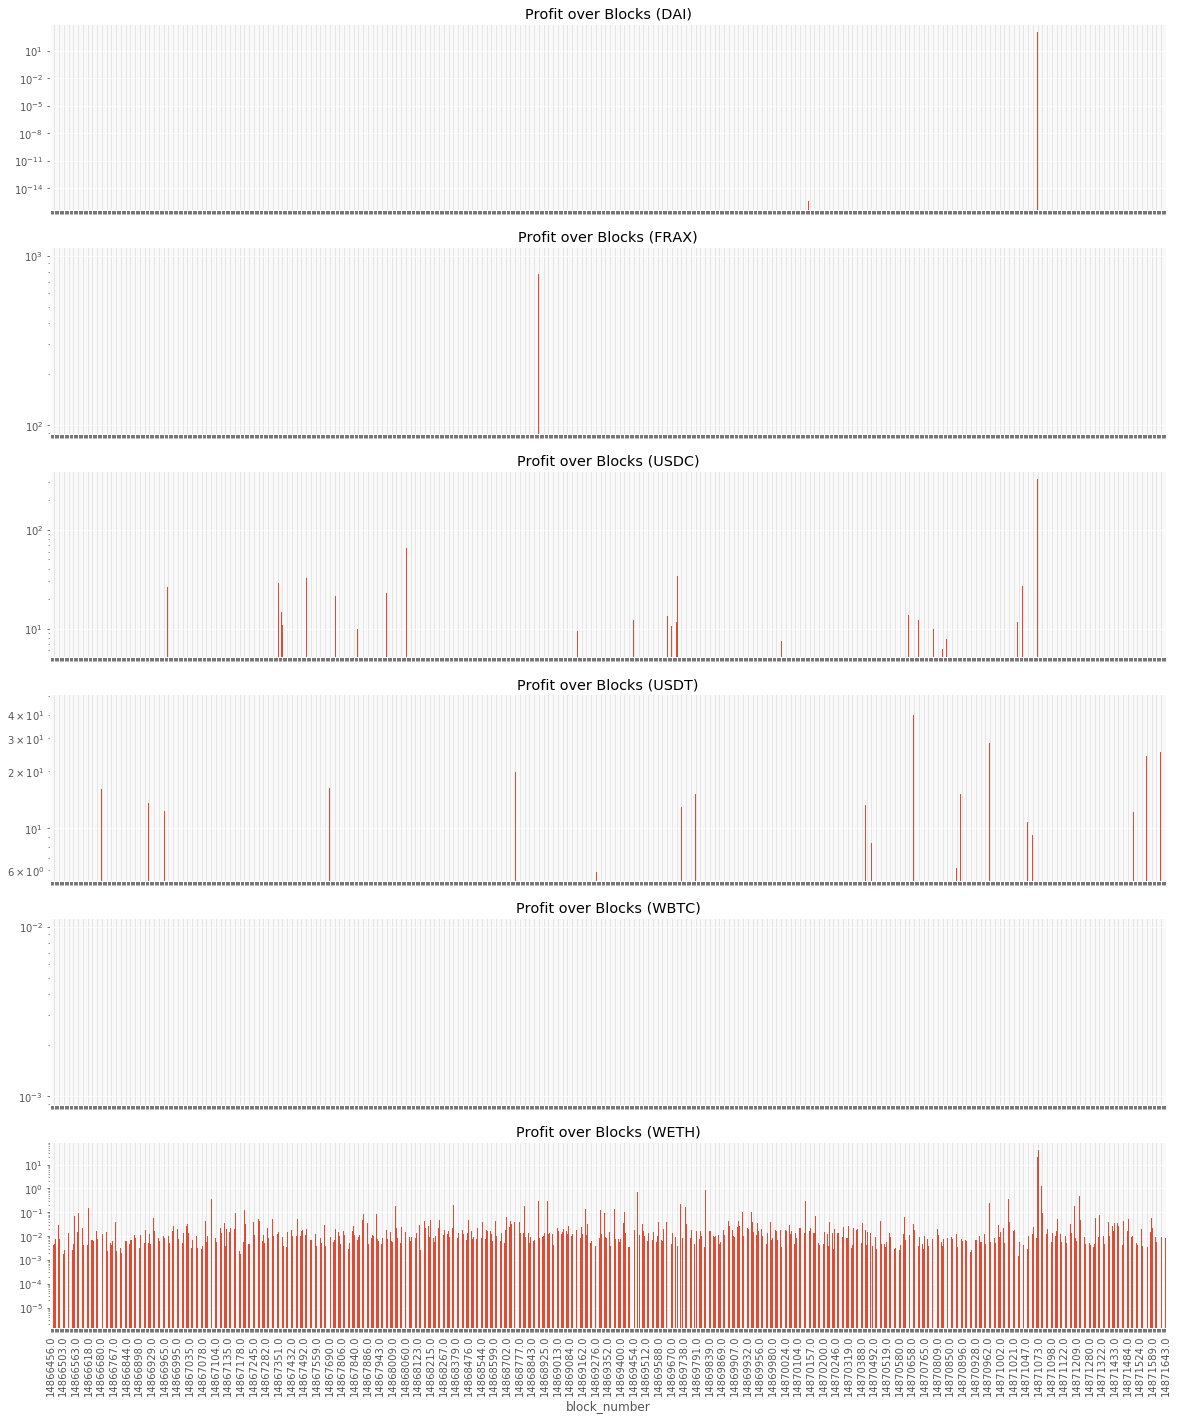

In [12]:
fig, ax = plt.subplots(
    df_arbs.profit_token_symbol.nunique(),
    1,
    figsize=(20, df_arbs.profit_token_symbol.nunique() * 4),
    sharex=True,
)

df_plot = (
    df_arbs.groupby(["block_number", "profit_token_symbol"])[["profit_amount"]]
    .sum()
    .reset_index()
    .sort_values("block_number")
    .pivot(columns="profit_token_symbol", index="block_number", values="profit_amount")
)

for i, prof_symbol in enumerate(df_plot.columns):
    df_plot[prof_symbol].plot(kind="bar", ax=ax[i]).set_title(
        f"Profit over Blocks ({prof_symbol})"
    )
    ax[i].set_yscale("log")

n = 10
[
    l.set_visible(False)
    for (i, l) in enumerate(fig.axes[-1].xaxis.get_ticklabels())
    if i % n != 0
]
pass

### Notes
* Would be interesting to plot VIX or another volatility measure over the above to see how VOL affects arb opps.

In [13]:
df_arbs.account_address.nunique()

64

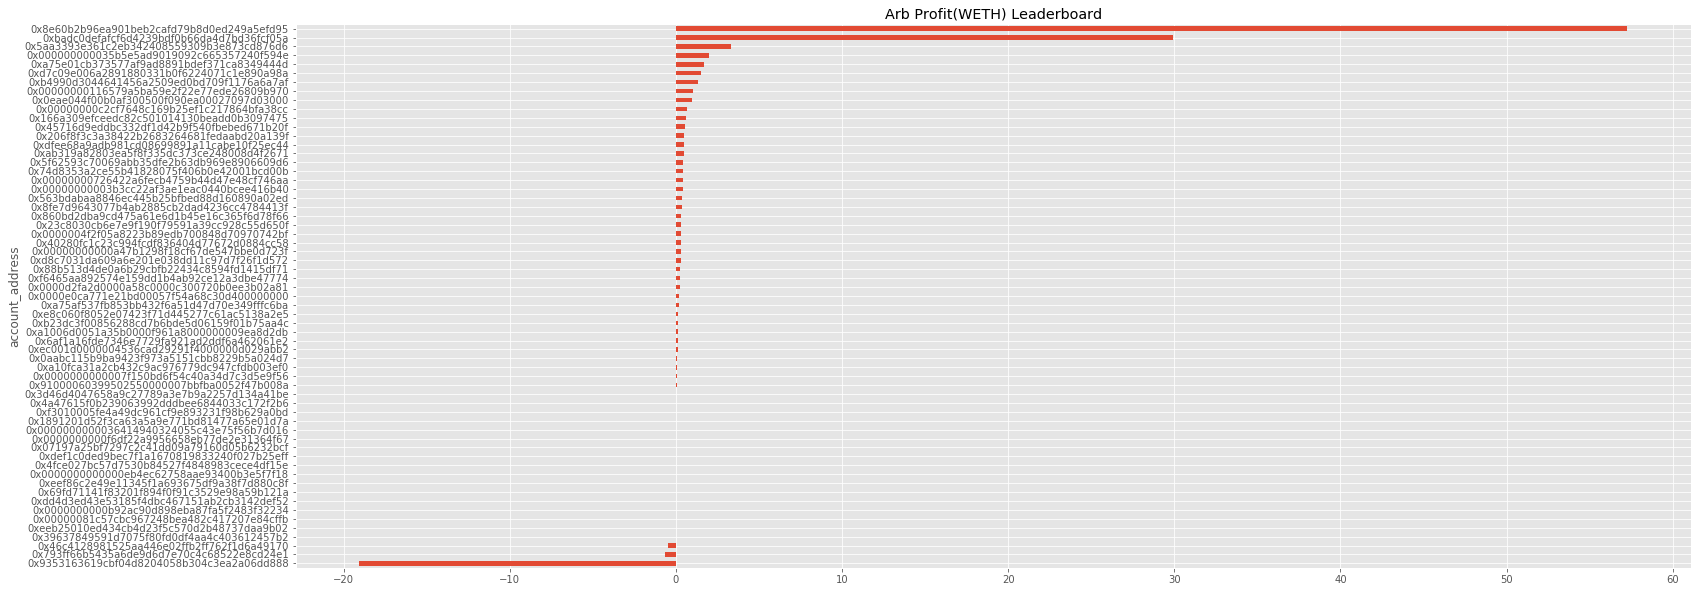

In [14]:
fig, ax = plt.subplots(figsize=(25, 10))
df_arbs[df_arbs.profit_token_symbol == "WETH"].groupby("account_address")[
    "profit_amount"
].sum().sort_values().plot(kind="barh").set_title("Arb Profit(WETH) Leaderboard")
pass

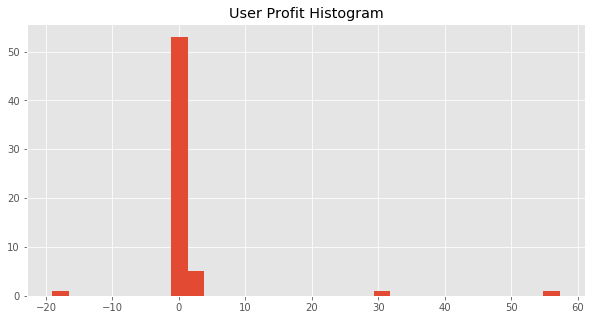

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
df_arbs[df_arbs.profit_token_symbol == "WETH"].groupby("account_address")[
    "profit_amount"
].sum().hist(bins=30).set_title("User Profit Histogram")
pass

In [16]:
# From here, only look at transactions which took profit in WETH
df_arbs = df_arbs[df_arbs.profit_token_symbol == "WETH"].copy()

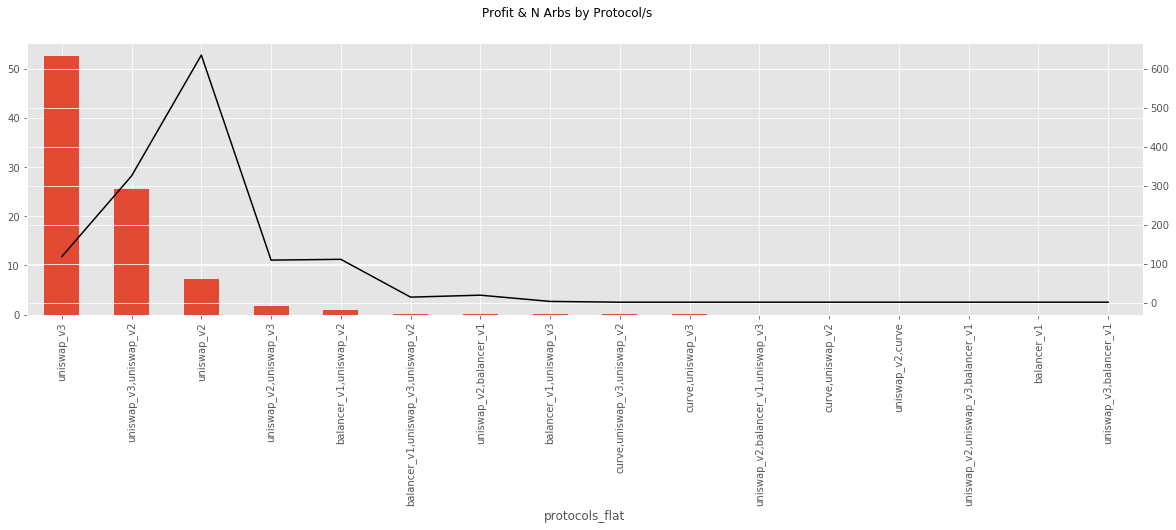

In [17]:
df_plot = (
    df_arbs.groupby("protocols_flat")
    .agg(total_profit_amount=("profit_amount", "sum"), n_arbs=("id", "nunique"))
    .sort_values("total_profit_amount", ascending=False)
)

fig, ax = plt.subplots(figsize=(20, 5))
ax2 = ax.twinx()
df_plot["total_profit_amount"].plot(kind="bar", ax=ax)
df_plot["n_arbs"].plot(kind="line", ax=ax2, color="black")

fig.suptitle("Profit & N Arbs by Protocol/s")
pass

In [18]:
df_plot.head()

,total_profit_amount,n_arbs
protocols_flat,,
uniswap_v3,52.692680,118
"uniswap_v3,uniswap_v2",25.653703,325
uniswap_v2,7.306487,635
"uniswap_v2,uniswap_v3",1.716489,109
"balancer_v1,uniswap_v2",0.893975,111


Text(0.5, 1.0, 'Profit Per Arb over Protocol/s')

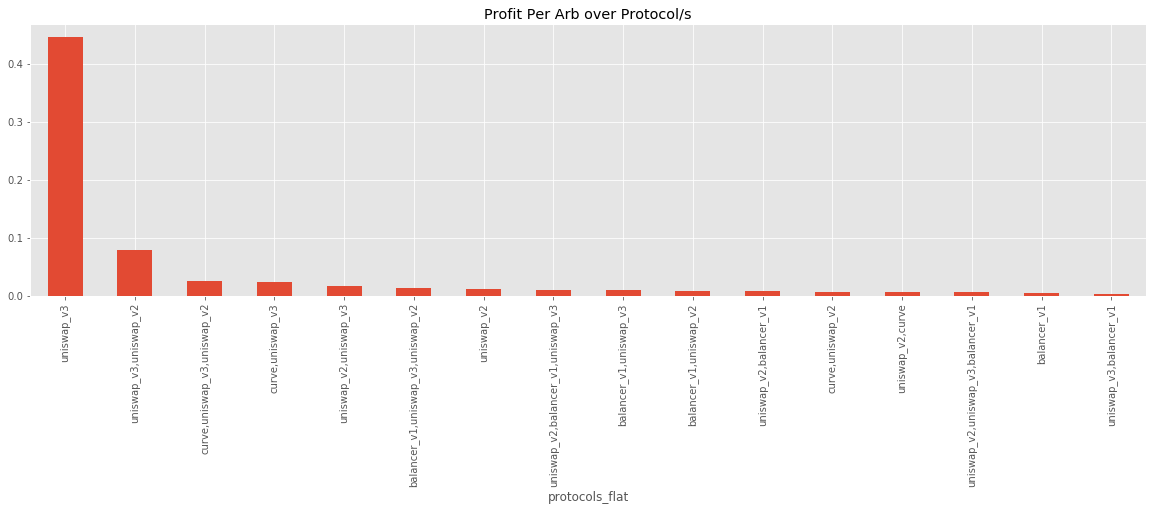

In [19]:
fig, ax = plt.subplots(figsize=(20, 5))
df_plot["profit_per_arb"] = df_plot.total_profit_amount / df_plot.n_arbs
df_plot["profit_per_arb"].sort_values(ascending=False).plot(kind="bar").set_title(
    "Profit Per Arb over Protocol/s"
)